In [2]:
!pip uninstall -q numpy tensorflow-estimator tensorflow -y
!pip install -q "numpy<1.19.0" "tensorflow-estimator<2.4.0,>=2.3.0" "tensorflow<2.4"
!pip install -q albumentations==0.5.2
!pip install -q git+https://github.com/mjkvaak/ImageDataAugmentor

     |████████████████████████████████| 72 kB 500 kB/s 
     |████████████████████████████████| 948 kB 11.9 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
     |████████████████████████████████| 49.9 MB 17 kB/s 


In [82]:
import glob
import json
import os
import time

import albumentations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from google.colab import files
from ImageDataAugmentor.image_data_augmentor import *
from PIL import ImageFilter, ImageOps
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm.auto import tqdm

print("Numpy          :", np.__version__)
print("Tensorflow     :", tf.__version__)
print("Keras          :", tf.keras.__version__)
print("albumentations :", albumentations.__version__)

Numpy          : 1.18.5
Tensorflow     : 2.3.4
Keras          : 2.4.0
albumentations : 0.5.2


In [77]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0
SPLIT = 5
IMG_SIZE = 224  # какого размера подаем изображения в сеть
path = "drive/MyDrive/Birds sort/"
PATH = "drive/MyDrive/Birds sort"

In [80]:
files = glob.glob(f"{PATH}/*/*")
files[:4]

['drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/info.json',
 'drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/001.jpg',
 'drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/002.jpg',
 'drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/003.jpg']

In [92]:
folders = glob.glob(f"{PATH}/*")  # folder for each bird
df = pd.DataFrame()


def process_folder(folder):
    photos = glob.glob(f"{folder}/*jpg")
    data = json.load(open(f"{folder}/info.json"))

    return pd.DataFrame(
        dict(
            photo=photos,
            latin=data["latin"],
            russian=data["russian"],
            english=data["english"],
            url=data["url"],
        )
    )


for folder in tqdm(folders):
    df = pd.concat([df, process_folder(folder)])

df.to_csv(f"{path}/bird_df.csv", index=False)

  0%|          | 0/78 [00:00<?, ?it/s]

In [93]:
df = pd.read_csv(f"{PATH}/bird_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9567 entries, 0 to 9566
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   photo    9567 non-null   object
 1   latin    9567 non-null   object
 2   russian  9567 non-null   object
 3   english  9567 non-null   object
 4   url      9567 non-null   object
dtypes: object(5)
memory usage: 373.8+ KB


In [94]:
data = df[["photo", "latin"]]
data.head(2)

,photo,latin
0,drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/...,Syrrhaptes paradoxus
1,drive/MyDrive/Birds sort/Syrrhaptes_paradoxus/...,Syrrhaptes paradoxus


Пример картинок


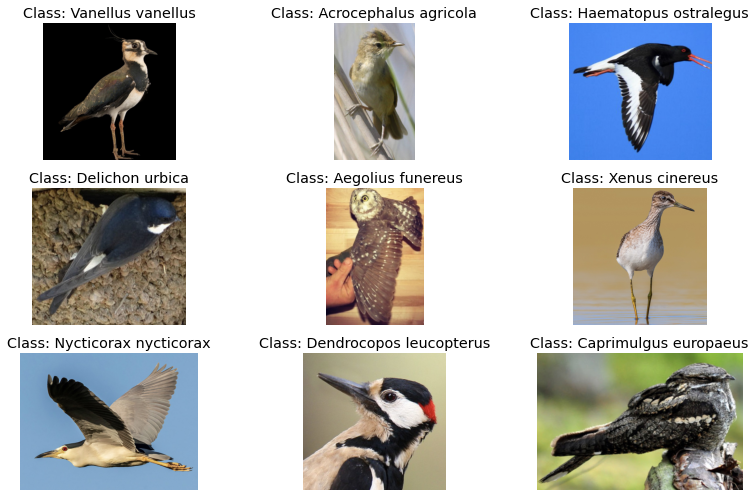

In [95]:
print("Пример картинок")
plt.figure(figsize=(12, 8))

random_image = data.sample(n=9)
random_image_paths = random_image["photo"].values
random_image_cat = random_image["latin"].values

for index, PATH in enumerate(random_image_paths):
    im = PIL.Image.open(f"{PATH}")
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title("Class: " + str(random_image_cat[index]))
    plt.axis("off")

plt.show()

In [96]:
train_val, hold_out = train_test_split(
    data, test_size=0.1, stratify=data["latin"], random_state=RANDOM_SEED
)  # hold_out только в конце, для визуальной проверки качества предсказаний и оценка модели
X, y = train_val["photo"], train_val["latin"]

In [97]:
AUGMENTATIONS = albumentations.Compose(
    [
        albumentations.HorizontalFlip(p=0.5),
        albumentations.Rotate(
            limit=10,
            interpolation=1,
            border_mode=4,
            value=None,
            mask_value=None,
            always_apply=False,
            p=0.8,
        ),
        albumentations.OneOf(
            [
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.3, contrast_limit=0.3
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.2, contrast_limit=0.2
                ),
                albumentations.RandomBrightnessContrast(
                    brightness_limit=0.1, contrast_limit=0.1
                ),
            ],
            p=0.7,
        ),
        albumentations.Blur(blur_limit=3, always_apply=False, p=0.5),
        albumentations.HueSaturationValue(
            hue_shift_limit=20,
            sat_shift_limit=30,
            val_shift_limit=20,
            always_apply=False,
            p=0.7,
        ),
        albumentations.RGBShift(
            r_shift_limit=20,
            g_shift_limit=20,
            b_shift_limit=20,
            always_apply=False,
            p=0.7,
        ),
        albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
        albumentations.ChannelShuffle(p=0.7),
        albumentations.CLAHE(
            clip_limit=3.0, tile_grid_size=(8, 8), always_apply=False, p=0.3
        ),
        albumentations.Resize(IMG_SIZE, IMG_SIZE),
    ]
)

In [98]:
# create train, valid generators
def Image_preprocessing(train, val, hold_out):
    height = 224
    width = 224
    channels = 3
    batch_size = 42
    img_shape = (height, width, channels)
    img_size = (height, width)
    length = len(val)
    valid_batch_size = sorted(
        [
            int(length / n)
            for n in range(1, length + 1)
            if length % n == 0 and length / n <= 80
        ],
        reverse=True,
    )[0]
    valid_steps = int(length / valid_batch_size)
    print("valid batch size: ", valid_batch_size, "  valid steps: ", valid_steps)
    tvgen_train = ImageDataAugmentor(augment=AUGMENTATIONS)
    tvgen_valid = ImageDataAugmentor()
    train_gen = tvgen_train.flow_from_dataframe(
        train,
        x_col="photo",
        y_col="latin",
        target_size=img_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=True,
        batch_size=batch_size,
    )
    valid_gen = tvgen_valid.flow_from_dataframe(
        val,
        x_col="photo",
        y_col="latin",
        target_size=img_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
    )
    hold_out_gen = tvgen_valid.flow_from_dataframe(
        hold_out,
        x_col="photo",
        y_col="latin",
        target_size=img_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=False,
        batch_size=batch_size,
    )
    classes = list(train_gen.class_indices.keys())
    class_count = len(classes)
    train_steps = int(len(train_gen.labels) / batch_size)
    return (
        train_gen,
        valid_gen,
        hold_out_gen,
        img_shape,
        train_steps,
        class_count,
        batch_size,
        valid_batch_size,
        valid_steps,
    )


# calculate the class weights
def class_weights(train_gen):
    class_weight = {}
    train_dict = train_gen.class_indices
    classes = list(train_dict.keys())
    class_count = len(classes)
    labels = train_gen.labels
    class_samples = np.zeros((class_count))
    for klass, index in train_dict.items():
        count = 0
        for label in labels:
            if label == index:
                count += 1
        class_samples[index] = count
    max_samples = np.max(class_samples)
    for i in range(class_count):
        class_weight[i] = max_samples / class_samples[i]
        if class_weight[i] <= 1.0:
            print(classes[i], " has the most samples of ", int(max_samples))
    return class_weight


# create function to show some image examples
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="blue", fontsize=16)
        plt.axis("off")
    plt.show()


# define function to print text in RGB foreground and background colors
def print_in_color(txt_msg, fore_tupple, back_tupple):
    # prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    # text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf, gf, bf = fore_tupple
    rb, gb, bb = back_tupple
    msg = "{0}" + txt_msg
    mat = f"\33[38;2;{rf};{gf};{bf};48;2;{rb};{gb};{bb}m"
    print(msg.format(mat), flush=True)
    print("\33[0m", flush=True)  # returns default print color to back to black


# show_image_samples(train_gen)
# create the model
def create_model(class_count):
    base_model = tf.keras.applications.EfficientNetB1(
        include_top=False, weights="imagenet", input_shape=img_shape, pooling="max"
    )
    x = base_model.output
    x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(
        256,
        kernel_regularizer=regularizers.l2(l=0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation="relu",
    )(x)
    x = Dropout(rate=0.45, seed=123)(x)
    output = Dense(class_count, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        Adamax(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# create a subclass of callbacks to control learning rate and print training results for each epoch
class LRA(keras.callbacks.Callback):
    reset = False
    count = 0
    stop_count = 0
    tepochs = 0

    def __init__(
        self,
        model,
        patience,
        stop_patience,
        threshold,
        factor,
        dwell,
        model_name,
        freeze,
        batches,
        initial_epoch,
    ):
        super(LRA, self).__init__()
        self.model = model
        self.patience = patience  # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience
        self.threshold = threshold  # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor  # factor by which to reduce the learning rate
        self.dwell = dwell
        self.lr = float(
            tf.keras.backend.get_value(model.optimizer.lr)
        )  # get the initiallearning rate and save it in self.lr
        self.highest_tracc = 0.0  # set highest training accuracy to 0
        self.lowest_vloss = np.inf  # set lowest validation loss to infinity
        # self.count=0 # initialize counter that counts epochs with no improvement
        # self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch = initial_epoch
        self.batches = batches
        # self.epochs=epochs
        best_weights = (
            self.model.get_weights()
        )  # set a class vaiable so weights can be loaded after training is completed
        msg = " "
        if freeze == True:
            msgs = f" Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback"
        else:
            msgs = f" Starting training using base model { model_name} training all layers "
        print_in_color(msgs, (244, 252, 3), (55, 65, 80))

    def on_train_begin(self, logs=None):
        # msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
        #                                                                                       'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        # # TODO: convert to f-string ^^^
        msg = f"{'Epoch':^6}{'Loss':^10}{'Accuracy':^9s}{'V_loss':^9s}{'V_acc':^9s}{'LR':^9s}{'Next LR':^9s}{'Monitor':^10s}{'Duration':^8s}{'Batch':^8s}"
        print_in_color(msg, (244, 252, 3), (55, 65, 80))

    def on_train_batch_begin(self, batch, logs=None):
        msg = "{0:83s}{1:4s}of {2:5s}".format(" ", str(batch), str(self.batches))
        print(
            msg, "\r", end=""
        )  # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs=None):
        self.now = time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later = time.time()
        duration = later - self.now
        lr = float(
            tf.keras.backend.get_value(self.model.optimizer.lr)
        )  # get the current learning rate
        current_lr = lr
        v_loss = logs.get("val_loss")  # get the validation loss for this epoch
        acc = logs.get("accuracy")  # get training accuracy
        v_acc = logs.get("val_accuracy")
        loss = logs.get("loss")
        # print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if (
            acc < self.threshold
        ):  # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = "accuracy"
            if acc > self.highest_tracc:  # training accuracy improved in the epoch
                self.highest_tracc = acc  # set new highest training accuracy
                LRA.best_weights = (
                    self.model.get_weights()
                )  # traing accuracy improved so save the weights
                self.count = 0  # set count to 0 since training accuracy improved
                self.stop_count = 0  # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                color = (0, 255, 0)
                self.lr = lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    self.lr = lr * self.factor  # adjust the learning by factor
                    tf.keras.backend.set_value(
                        self.model.optimizer.lr, self.lr
                    )  # set the learning rate in the optimizer
                    self.count = 0  # reset the count to 0
                    self.stop_count = self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(
                            LRA.best_weights
                        )  # return to better point in N space
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1  # increment patience counter
        else:  # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = "val_loss"
            if v_loss < self.lowest_vloss:  # check if the validation loss improved
                self.lowest_vloss = (
                    v_loss  # replace lowest validation loss with new validation loss
                )
                LRA.best_weights = (
                    self.model.get_weights()
                )  # validation loss improved so save the weights
                self.count = 0  # reset count since validation loss improved
                self.stop_count = 0
                color = (0, 255, 0)
                self.lr = lr
            else:  # validation loss did not improve
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    self.lr = self.lr * self.factor  # adjust the learning rate
                    self.stop_count = (
                        self.stop_count + 1
                    )  # increment stop counter because lr was adjusted
                    self.count = 0  # reset counter
                    tf.keras.backend.set_value(
                        self.model.optimizer.lr, self.lr
                    )  # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(
                            LRA.best_weights
                        )  # return to better point in N space
                else:
                    self.count = self.count + 1  # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc
        msg = f"{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}"
        print_in_color(msg, color, (55, 65, 80))
        if (
            self.stop_count > self.stop_patience - 1
        ):  # check if learning rate has been adjusted stop_count times with no improvement
            msg = f" training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement"
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            self.model.stop_training = True  # stop training


def train_model(train_steps, train_gen, valid_gen, class_weight):
    epochs = 12
    patience = (
        1  # number of epochs to wait to adjust lr if monitored value does not improve
    )
    stop_patience = 3  # number of epochs to wait before stopping training if monitored value does not improve
    threshold = 0.9  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
    factor = 0.5  # factor to reduce lr by
    dwell = True  # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
    freeze = False  # if true free weights of  the base model
    batches = train_steps
    model_name = "EfficientNetB1"

    model = create_model(class_count)
    callbacks = [
        LRA(
            model=model,
            patience=patience,
            stop_patience=stop_patience,
            threshold=threshold,
            factor=factor,
            dwell=dwell,
            model_name=model_name,
            freeze=freeze,
            batches=batches,
            initial_epoch=0,
        )
    ]
    LRA.tepochs = epochs  # used to determine value of last epoch for printing
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=valid_gen,
        validation_steps=None,
        shuffle=False,
        initial_epoch=0,
        class_weight=class_weight,
    )
    return model, history


# Indented block define function to plot the training data
def tr_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history["accuracy"]
    tloss = tr_data.history["loss"]
    vacc = tr_data.history["val_accuracy"]
    vloss = tr_data.history["val_loss"]
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  #  this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use("fivethirtyeight")
    sc_label = "best epoch= " + str(index_loss + 1 + start_epoch)
    vc_label = "best epoch= " + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, "r", label="Training loss")
    axes[0].plot(Epochs, vloss, "g", label="Validation loss")
    axes[0].scatter(
        index_loss + 1 + start_epoch, val_lowest, s=150, c="blue", label=sc_label
    )
    axes[0].set_title("Training and Validation Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[1].plot(Epochs, tacc, "r", label="Training Accuracy")
    axes[1].plot(Epochs, vacc, "g", label="Validation Accuracy")
    axes[1].scatter(
        index_acc + 1 + start_epoch, acc_highest, s=150, c="blue", label=vc_label
    )
    axes[1].set_title("Training and Validation Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.tight_layout
    plt.show()


# evaluate model on the vall set then save the model
def evaluate_accuracy_and_save_model(
    model, history, valid_gen, batch_size, valid_steps
):
    tr_plot(history, 0)
    save_dir = r"drive/MyDrive/"
    subject = "birds"
    acc = (
        model.evaluate(
            valid_gen,
            batch_size=batch_size,
            verbose=1,
            steps=valid_steps,
            return_dict=False,
        )[1]
        * 100
    )
    msg = f"accuracy on the valid set is {acc:5.2f} %"
    print_in_color(msg, (0, 255, 0), (55, 65, 80))
    save_id = str(
        "birds" + "-" + subject + "-" + str(acc)[: str(acc).rfind(".") + 3] + ".h5"
    )
    save_loc = os.path.join(save_dir, save_id)
    model.save(save_loc)
    return acc, save_dir, subject

Starting training. TRAIN: 6888, TEST: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  183
27025408/27018416 [==============================] - 0s 0us/step
 Starting training using base model EfficientNetB1 training all layers 

Epoch    Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 12.5950 - accuracy: 0.4006  1 /12    12.595   40.055   7.42641  85.366   0.00100  0.00100  accuracy  2563.88 

164/164 [==============================] - 2540s 15s/step - loss: 12.5950 - accuracy: 0.4006 - val_loss: 7.4264 - val_accuracy: 0.8537
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 7.9858 - accuracy: 0.7920 2 /12     7.986   79.196   6.10049  90.999 

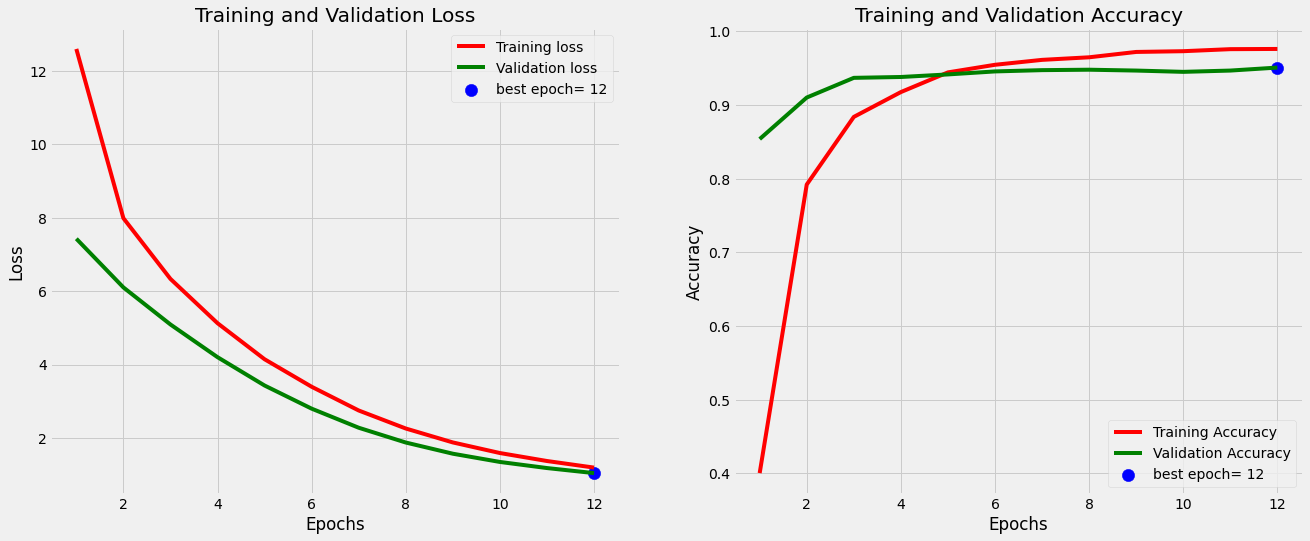

41/41 [==============================] - 23s 553ms/step - loss: 1.0435 - accuracy: 0.9506
accuracy on the valid set is 95.06 %

Starting training. TRAIN: 6888, TEST: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  183
 Starting training using base model EfficientNetB1 training all layers 

Epoch    Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 12.8331 - accuracy: 0.3820 1 /12    12.833   38.197   7.54025  80.778   0.00100  0.00100  accuracy   219.04 

164/164 [==============================] - 202s 1s/step - loss: 12.8331 - accuracy: 0.3820 - val_loss: 7.5403 - val_accuracy: 0.8078
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 8.0753 - 

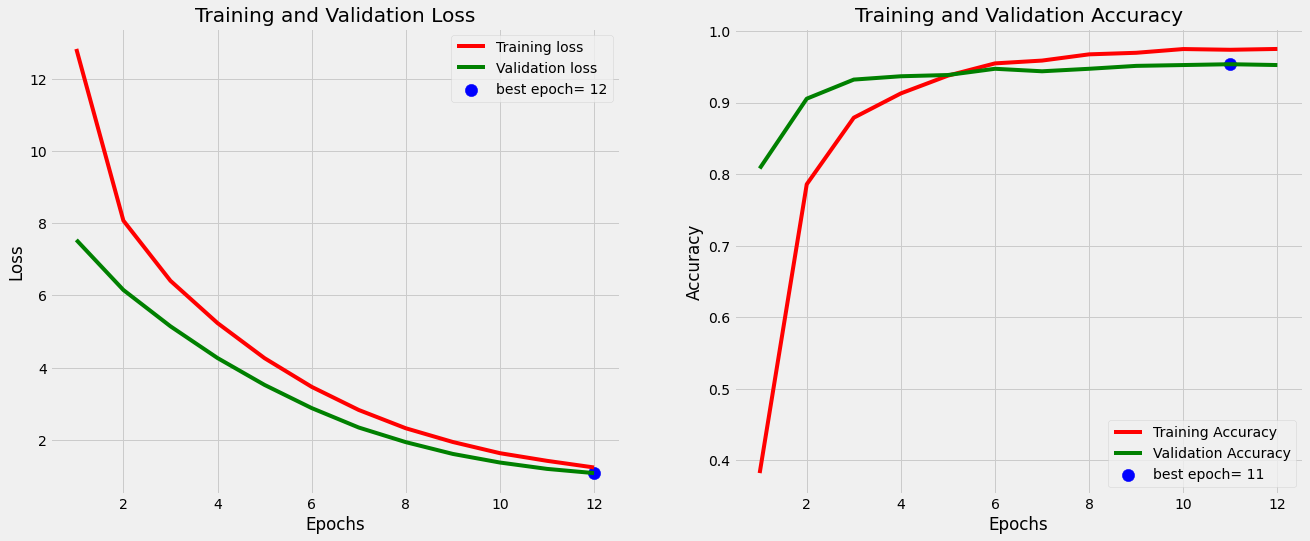

41/41 [==============================] - 23s 556ms/step - loss: 1.0772 - accuracy: 0.9524
accuracy on the valid set is 95.24 %

Starting training. TRAIN: 6888, TEST: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  183
 Starting training using base model EfficientNetB1 training all layers 

Epoch    Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 12.5470 - accuracy: 0.4072 1 /12    12.547   40.723   7.54121  85.134   0.00100  0.00100  accuracy   218.99 

164/164 [==============================] - 203s 1s/step - loss: 12.5470 - accuracy: 0.4072 - val_loss: 7.5412 - val_accuracy: 0.8513
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 7.9297 - 

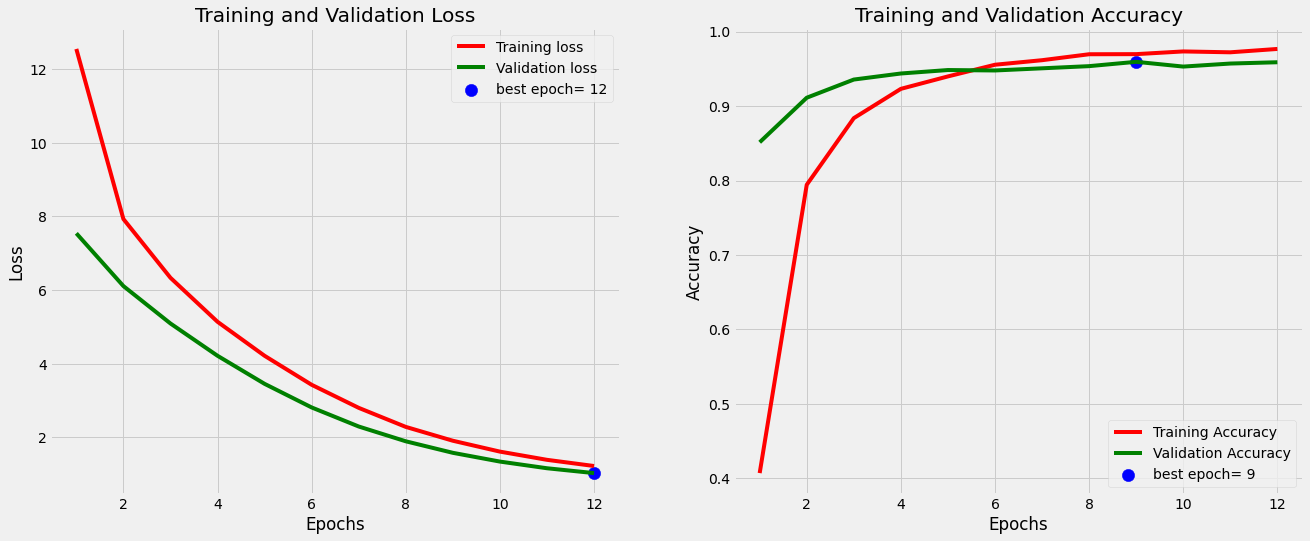

41/41 [==============================] - 23s 570ms/step - loss: 1.0318 - accuracy: 0.9588
accuracy on the valid set is 95.88 %

Starting training. TRAIN: 6888, TEST: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  183
 Starting training using base model EfficientNetB1 training all layers 

Epoch    Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 12.6273 - accuracy: 0.3918 1 /12    12.627   39.184   7.42385  83.217   0.00100  0.00100  accuracy   218.52 

164/164 [==============================] - 202s 1s/step - loss: 12.6273 - accuracy: 0.3918 - val_loss: 7.4239 - val_accuracy: 0.8322
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 7.9631 - 

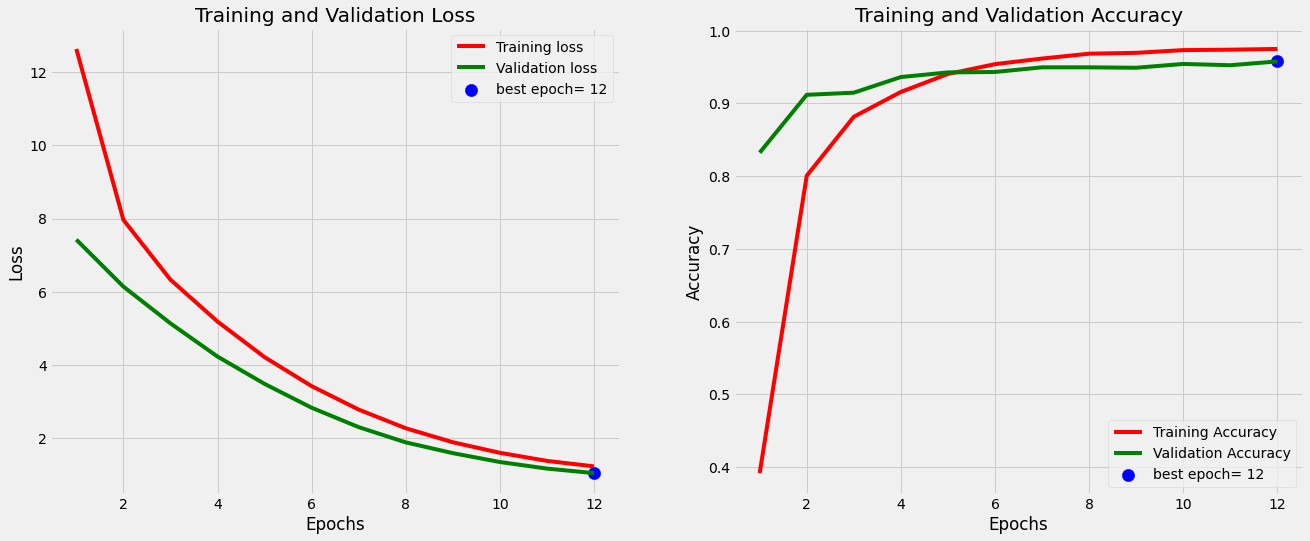

41/41 [==============================] - 22s 541ms/step - loss: 1.0526 - accuracy: 0.9576
accuracy on the valid set is 95.76 %

Starting training. TRAIN: 6888, TEST: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  184
 Starting training using base model EfficientNetB1 training all layers 

Epoch    Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

Epoch 1/12
164/164 [==============================] - ETA: 0s - loss: 12.9285 - accuracy: 0.3663 1 /12    12.928   36.629   7.61403  80.314   0.00100  0.00100  accuracy   219.48 

164/164 [==============================] - 202s 1s/step - loss: 12.9285 - accuracy: 0.3663 - val_loss: 7.6140 - val_accuracy: 0.8031
Epoch 2/12
164/164 [==============================] - ETA: 0s - loss: 8.1319 - 

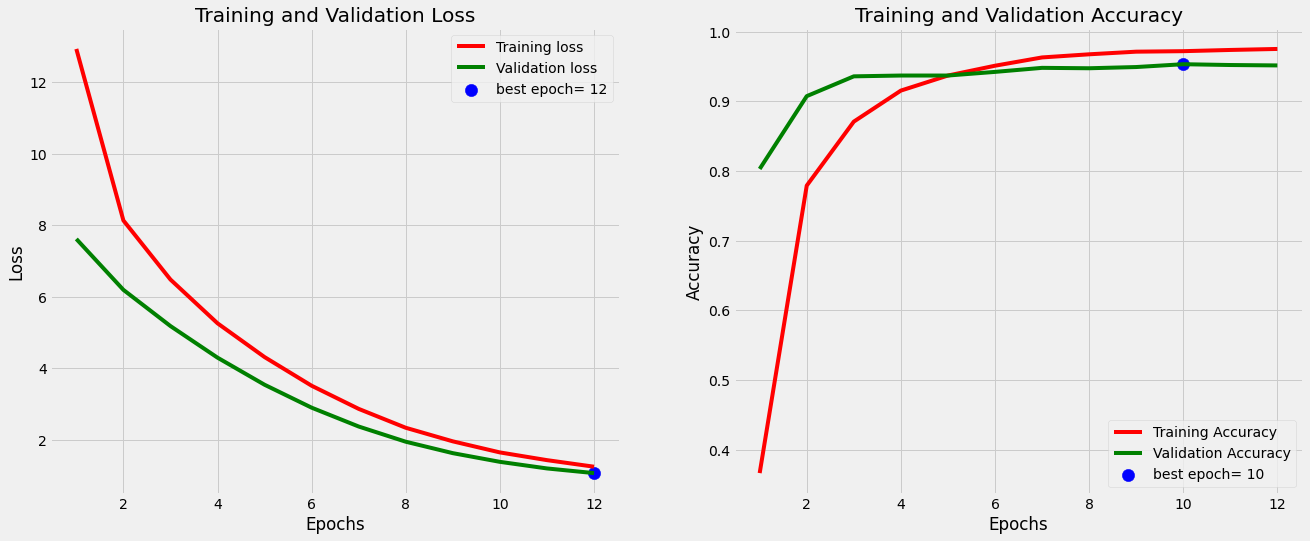

41/41 [==============================] - 24s 574ms/step - loss: 1.0662 - accuracy: 0.9518
accuracy on the valid set is 95.18 %



In [ ]:
accuracy_list = []

skf = StratifiedKFold(n_splits=SPLIT, shuffle=True, random_state=RANDOM_SEED)
for train_index, val_index in skf.split(X, y):
    train, val = train_val.iloc[train_index], train_val.iloc[val_index]
    print(f"Starting training. TRAIN: {len(train)}, TEST: {len(val)}")

    # generate input data and train model
    (
        train_gen,
        valid_gen,
        hold_out_gen,
        img_shape,
        train_steps,
        class_count,
        batch_size,
        valid_batch_size,
        valid_steps,
    ) = Image_preprocessing(train, val, hold_out)
    class_weight = class_weights(train_gen)
    model, history = train_model(train_steps, train_gen, valid_gen, class_weight)

    # check model accuracy
    acc, save_dir, subject = evaluate_accuracy_and_save_model(
        model, history, valid_gen, batch_size, valid_steps
    )
    accuracy_list.append(acc)

In [ ]:
round(np.mean(accuracy_list), 1)

In [99]:
accuracy_list = []

skf = StratifiedKFold(n_splits=SPLIT, shuffle=True, random_state=RANDOM_SEED)
train_index, val_index = next(skf.split(X, y))
train, val = train_val.iloc[train_index], train_val.iloc[val_index]
print(f"Starting training. TRAIN: {len(train)}, VAL: {len(val)}")

# generate input data and train model
(
    train_gen,
    valid_gen,
    hold_out_gen,
    img_shape,
    train_steps,
    class_count,
    batch_size,
    valid_batch_size,
    valid_steps,
) = Image_preprocessing(train, val, hold_out)
class_weight = class_weights(train_gen)

model = create_model(class_count)
model.load_weights("drive/MyDrive/birds-birds-95.87.h5")

Starting training. TRAIN: 6888, VAL: 1722
valid batch size:  42   valid steps:  41
Found 6888 validated image filenames belonging to 78 classes.
Found 1722 validated image filenames belonging to 78 classes.
Found 957 validated image filenames belonging to 78 classes.
Panurus biarmicus  has the most samples of  183


Out-of-sample model accuracy: 96.1%



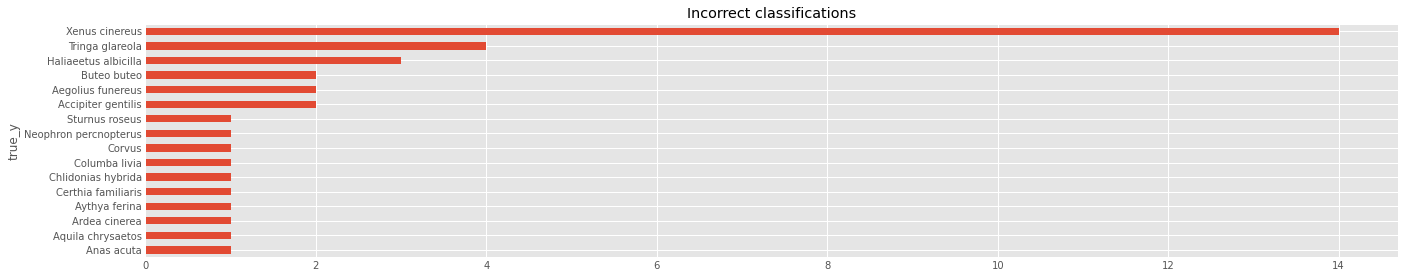

In [102]:
def evaluate_hold_out_accuracy(model, hold_out_gen):
    preds = model.predict(hold_out_gen)
    pred_y = np.argmax(preds, axis=-1)  # multiple categories
    label_map = {v: k for k, v in hold_out_gen.class_indices.items()}  # flip k,v

    pred_y = [label_map[k] for k in pred_y]
    true_y = [label_map[k] for k in hold_out_gen.labels]

    df = pd.DataFrame(dict(pred_y=pred_y, true_y=true_y))
    accuracy = len(df.query("pred_y == true_y")) / len(df) * 100
    print_in_color(
        f"Out-of-sample model accuracy: {accuracy:.1f}%", (200, 0, 0), (200, 200, 200)
    )
    plt.style.use("ggplot")
    _ = (
        df.query("pred_y != true_y")
        .pivot_table(columns="true_y", aggfunc="size")
        .sort_values()
        .plot(kind="barh", figsize=[20, 4], title="Incorrect classifications")
    )


evaluate_hold_out_accuracy(model, hold_out_gen)